In [19]:
cd ~/Desktop/workbench/cs330-final

/Users/gautam/Desktop/workbench/cs330-final


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import itertools

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import datasets
import model
import utils
import train

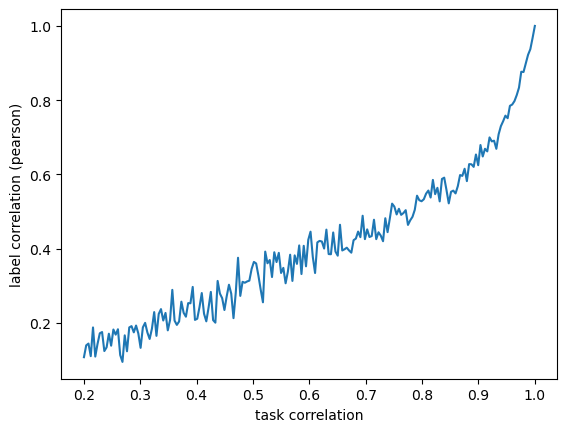

In [56]:
rs = []
ps = np.linspace(0.2, 1, 200)
for p in ps:
    x, y = utils.generate_task_pairs(1, 1000, dim=128, relatedness=p, c=1., m=6, noise_std=0.01)
    y1, y2 = y
    r = np.sum((y1 - np.mean(y1)) * (y2 - np.mean(y2))) / np.sqrt(np.sum((y1 - np.mean(y1))**2)*np.sum((y2 - np.mean(y2))**2))
    rs.append(r)

plt.xlabel('task correlation')
plt.ylabel('label correlation (pearson)')
plt.plot(ps, rs)

tensor(0.0972)

## Task Setup
Setup datasets, loss functions, etc.

In [917]:
bs = 1024


x, y = utils.generate_task_pairs(1, 50000, dim=128, relatedness=1., c=1., m=6, noise_std=0.01)
x = x.astype(np.float32)
y = y.astype(np.float32)
x = (torch.tensor(x))
y = (torch.tensor(y))
y1, y2 = y
n_train = 49000

mnist_train = list(zip(x[:n_train], y1[:n_train]))
fmnist_train = list(zip(x[:n_train], y2[:n_train]))

mnist_val = list(zip(x[n_train:], y1[n_train:]))
fmnist_val = list(zip(x[n_train:], y2[n_train:]))

mnist_train_loader = DataLoader(mnist_train, batch_size=bs, shuffle=True, drop_last=True)
fmnist_train_loader = DataLoader(fmnist_train, batch_size=bs, shuffle=True, drop_last=True)

mnist_iter = itertools.cycle(mnist_train_loader)
fmnist_iter = itertools.cycle(fmnist_train_loader)

 16%|█████████▊                                                     | 782/5000 [58:23<5:14:55,  4.48s/it]


In [918]:
(x.mean(), x.var()), (y1.mean(), y1.var()), (y2.mean(), y2.var())

((tensor(-0.0002), tensor(0.9997)),
 (tensor(0.1291), tensor(4.9862)),
 (tensor(0.1292), tensor(4.9868)))

In [919]:
tasks = {
    'mnist': {
        'train_iter': mnist_iter,
        'eval_ds': mnist_val,
        'loss': lambda logits, labels: F.mse_loss(logits, labels),
        'predict': lambda logits: logits,
        'metric': lambda yh, y: F.mse_loss(yh, y).detach().numpy(),
    },
    'fashion_mnist': {
        'train_iter': fmnist_iter,
        'eval_ds': fmnist_val,
        'loss': lambda logits, labels: F.mse_loss(logits, labels),
        'predict': lambda logits: logits,
        'metric': lambda yh, y: F.mse_loss(yh, y).detach().numpy(),
    },
}

## Compute surgical placements

In [841]:
class SharedMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.LinearBackbone()
        self.head = nn.Linear(256, 1)
    
    def forward(self, x, task):
        return self.head(self.backbone(x)).view(-1) 


shared_mtl = SharedMTL({'mnist': tasks['mnist']})
exp = train.train_and_evaluate(
    model=shared_mtl, 
    tasks={'mnist': tasks['mnist']}, 
    steps=5000, 
    lr=1e-4, eval_every=100)



  0%|                                                                           | 0/5000 [00:00<?, ?it/s]

  0%|▏                                                                | 11/5000 [00:00<00:47, 104.49it/s]

  0%|▎                                                                | 25/5000 [00:00<00:41, 120.36it/s]

  1%|▌                                                                | 39/5000 [00:00<00:39, 126.09it/s]

  1%|▋                                                                | 55/5000 [00:00<00:36, 136.64it/s]

  1%|▉                                                                | 73/5000 [00:00<00:32, 151.48it/s]

  2%|█▏                                                               | 91/5000 [00:00<00:30, 158.77it/s]

  2%|█▍                                                              | 109/5000 [00:00<00:29, 164.79it/s]

  3%|█▋                                                              | 128/5000 [00:00<00:28, 170.78it/s]

  3%|█▉                            

KeyboardInterrupt: 

In [771]:
grads, loss, rgn = train.get_gradients(
    model=shared_mtl,
    tasks={'fashion_mnist': tasks['fashion_mnist']}, 
    steps=500, 
    lr=1e-5,
)

100%|█████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.79it/s]


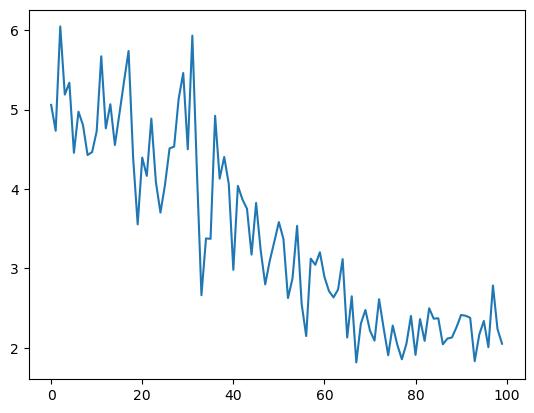

In [795]:
plt.plot([l['fashion_mnist'] for l in loss])

In [775]:
param_keys = ['backbone.' + k for k in list(shared_mtl.backbone.state_dict().keys())]

for k in param_keys:
    ri = np.mean([r['fashion_mnist'][k] for r in rgn])
    print(k, ri)

backbone.net.0.weight 0.91727966
backbone.net.0.bias 0.9964806
backbone.net.2.weight 1.7018598
backbone.net.2.bias 4.4168205
backbone.net.4.weight 0.22409311
backbone.net.4.bias 1.0791616


['backbone.net.0.weight', 'backbone.net.0.bias', 'backbone.net.2.weight', 'backbone.net.2.bias', 'backbone.net.4.weight', 'backbone.net.4.bias', 'head.weight', 'head.bias']
tensor(0.0086)
tensor(-0.0008)
tensor(0.0004)
tensor(0.0019)
tensor(-0.0009)
tensor(-0.0011)
tensor(-0.0181)
tensor(-0.0172)


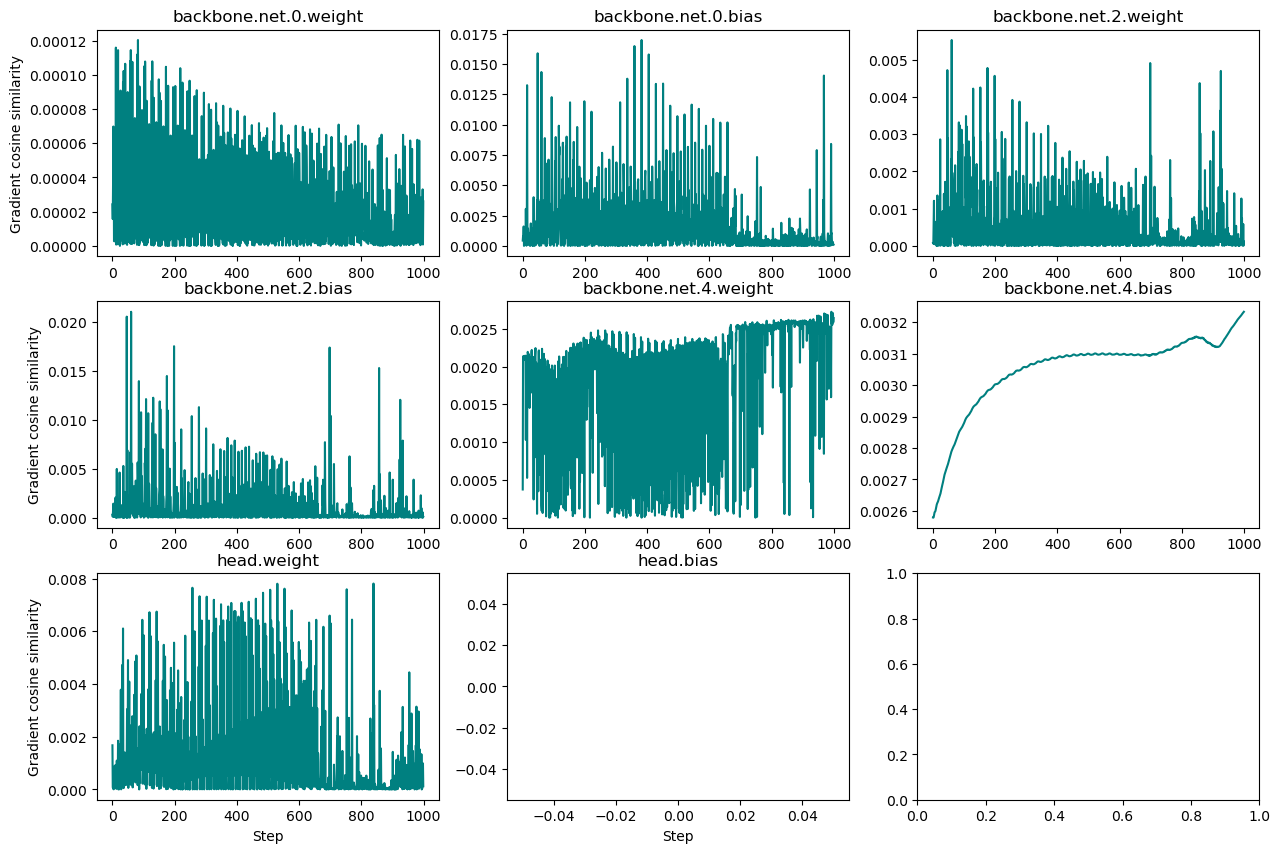

In [713]:
param_keys = [k for k in list(shared_mtl.state_dict().keys())]
print(param_keys)

heuristic_results = {}

# plots
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, key in enumerate(param_keys):
    # get gradients
    g1 = utils.stack_grad(grads, 'fashion_mnist', key)
    z = g1.mean(axis=-1) ** 2 / g1.var(axis=-1)
    print(g1[0][0])
    
    # plot
    row, col = i // n_cols, i % n_cols
    ax = axes[row][col]    
    
    ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    # ax.set_ylim([-1.1, 1.1])
    ax.plot(z, color='teal')#, alpha=0.2)
    # ax.plot(fh_smoothed, color='cyan')

## Compute gradient alignments

In [866]:
import copy

class SharedMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.LinearBackbone()
        x = nn.Linear(256, 1)
        self.heads = nn.ModuleDict({
            task: copy.deepcopy(x)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x)).view(-1) 

shared_mtl = SharedMTL(tasks.keys())
grads, loss, rgn = train.get_gradients(
    model=shared_mtl,
    tasks=tasks, 
    steps=200, 
    lr=1e-4,
)

100%|██████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.96it/s]


In [867]:
a = batches[0]['mnist']
b = batches[1]['fashion_mnist']

print((a[0] == b[0]).all(), (a[1] == b[1]).all())
# loss

tensor(False) tensor(False)


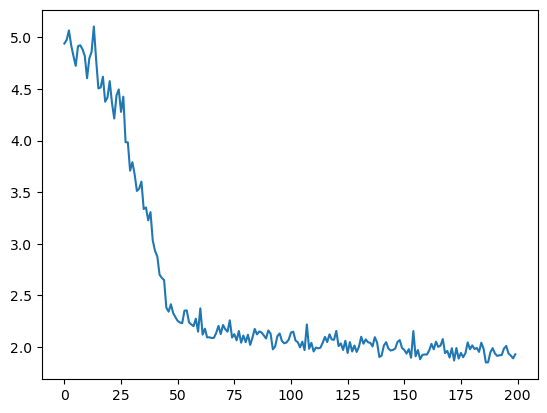

In [868]:
# grads[0]['mnist']['backbone.net.0.weight'], grads[0]['fashion_mnist']['backbone.net.0.weight']

plt.plot([np.mean(list(v.values())) for v in loss])

['backbone.net.0.weight', 'backbone.net.0.bias', 'backbone.net.2.weight', 'backbone.net.2.bias', 'backbone.net.4.weight', 'backbone.net.4.bias']


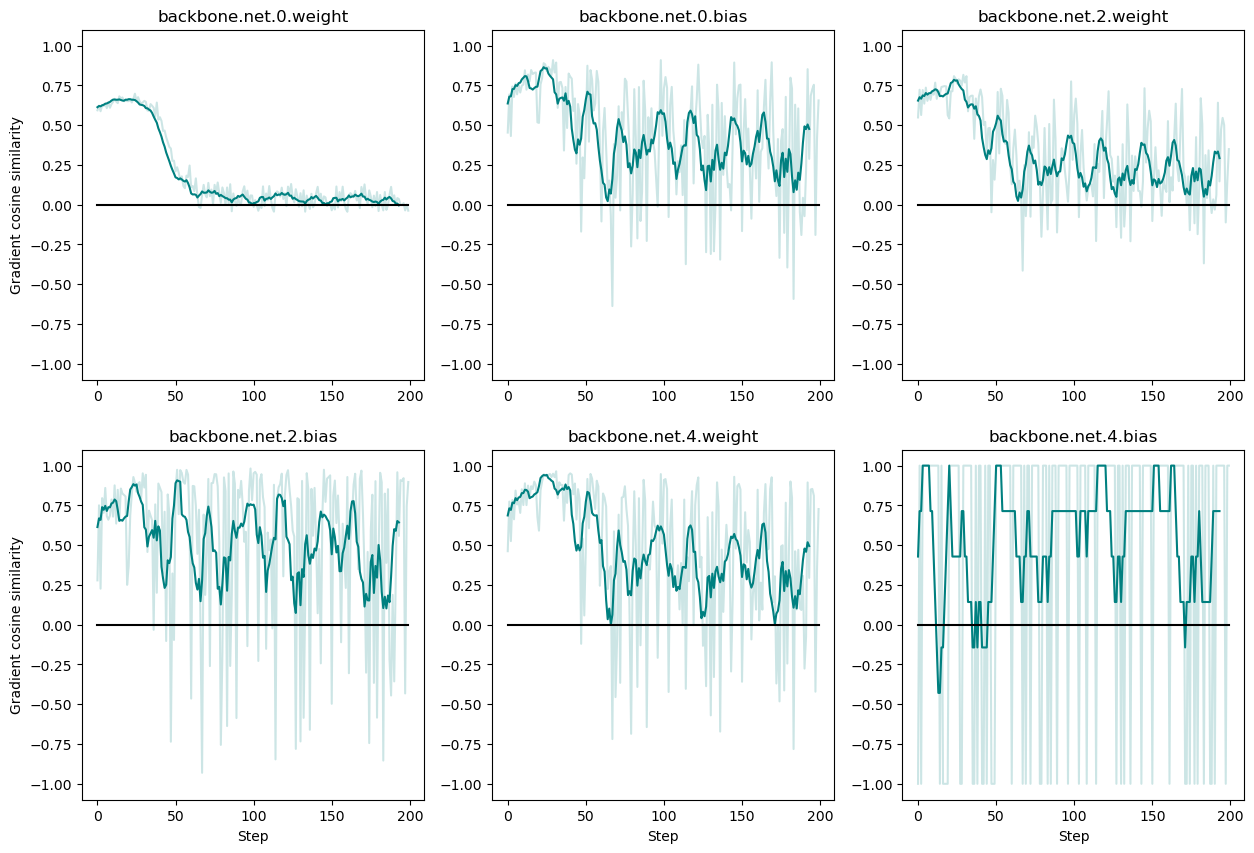

In [869]:
param_keys = ['backbone.' + k for k in list(shared_mtl.backbone.state_dict().keys())]
print(param_keys)

heuristic_results = {}

# plots
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, key in enumerate(param_keys):
    # get gradients
    g0 = utils.stack_grad(grads, 'mnist', key)
    g1 = utils.stack_grad(grads, 'fashion_mnist', key)
    
    r0 = utils.stack_grad(rgn, 'mnist', key)
    r1 = utils.stack_grad(rgn, 'fashion_mnist', key)
    
    # heuristics computations
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = utils.low_pass_filter(cosine[None], filter_size=7)[0][0]    
    avg_smoothed_cos = smooth_cos.mean()
    std_cos = cosine.std()
    
    g0_norm = np.linalg.norm(g0, axis=-1)
    g1_norm = np.linalg.norm(g1, axis=-1)
    mag_sim = (2 * g0_norm * g1_norm) / (g0_norm ** 2 + g1_norm ** 2)
    mag_sim_smoothed = utils.low_pass_filter(mag_sim[None], filter_size=20)[0][0]
    
    fh = mag_sim * cosine.numpy()
    fh_smoothed = utils.low_pass_filter(fh[None], filter_size=10)[0][0]
    
    heuristic_results[key] = {'avg_cos': avg_smoothed_cos, 
                              'std_cos': std_cos}
      
    # plot
    row, col = i // n_cols, i % n_cols
    ax = axes[row][col]    
    
    if avg_smoothed_cos >= 0:
        ax.set_title(key)#, color='green')
    else:
        ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    ax.set_ylim([-1.1, 1.1])
    ax.plot(cosine, color='teal', alpha=0.2)
    ax.plot(smooth_cos, color='teal')
    ax.plot(np.zeros_like(cosine), color='black')
    # ax.plot(mag_sim, color='purple', alpha=0.2)
    # ax.plot(mag_sim_smoothed, color='purple')
    # ax.plot(r0 - r1)

    # ax.plot(fh_smoothed, color='cyan')

In [860]:
heuristic_results

{'backbone.net.0.weight': {'avg_cos': -0.40334392, 'std_cos': tensor(0.2507)},
 'backbone.net.0.bias': {'avg_cos': -0.23294936, 'std_cos': tensor(0.3443)},
 'backbone.net.2.weight': {'avg_cos': -0.36131382, 'std_cos': tensor(0.2852)},
 'backbone.net.2.bias': {'avg_cos': -0.07076235, 'std_cos': tensor(0.4484)},
 'backbone.net.4.weight': {'avg_cos': -0.32024345, 'std_cos': tensor(0.4366)},
 'backbone.net.4.bias': {'avg_cos': 0.09714195, 'std_cos': tensor(0.9296)}}

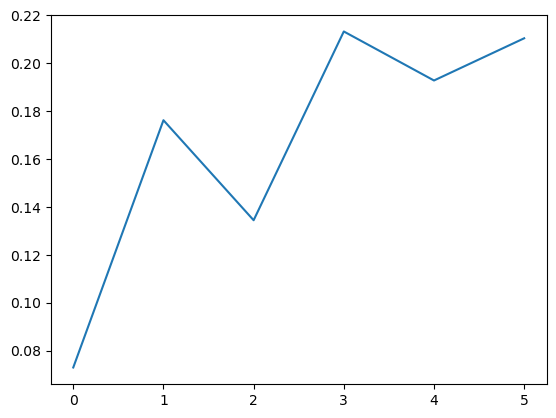

In [870]:
h = np.array([heuristic_results[p]['avg_cos'] for p in param_keys])
h = h / np.sum(h)
plt.plot(h)

## Experiments

In [920]:
mtl = SharedMTL(tasks.keys())
fully_shared_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.63it/s]


In [921]:
class SeparateMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbones = nn.ModuleDict({
            task: model.LinearBackbone()
            for task in task_keys
        })
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbones[task](x)).view(-1)

mtl = SeparateMTL(tasks.keys())
separate_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.22it/s]


In [881]:
class SurgicalMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.Shareable(
            mdl=model.LinearBackbone(),
            task_keys=list(task_keys),
            shared_params=['net.2.bias', 'net.2.weight']
        )
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x, task)).view(-1)

mtl = SurgicalMTL(tasks.keys())
surgical_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=1000,
    lr=1e-4,
    eval_every=50,
)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.56it/s]


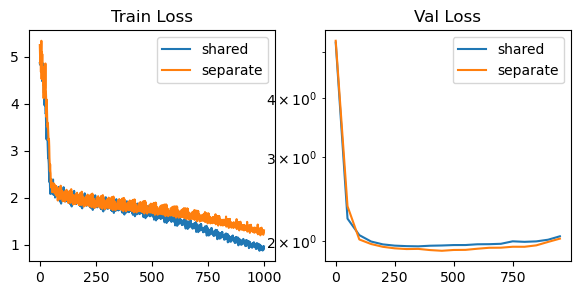

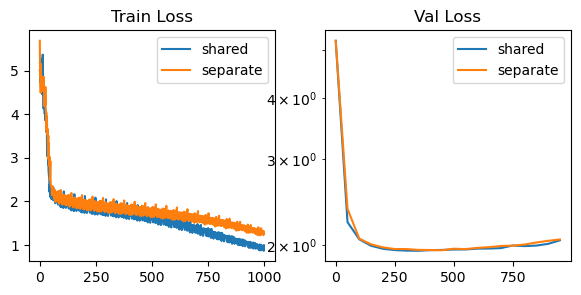

In [922]:
for task_name in tasks:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        # ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [(s, l[task_name]) for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        # plot
        ax = axes[0]
        tl_x, tl_y = zip(*tl)
        ax.plot(tl_x, tl_y, label=f'{exp_name}')#_{task_name}')
        ax.set_title('Train Loss')
        # ax.set_yscale('log')
        ax.legend()

        ax = axes[1]
        el_x, el_y = zip(*el)
        ax.plot(el_x, el_y, label=f'{exp_name}')#_{task_name}')
        ax.set_title('Val Loss')
        ax.set_yscale('log')
        ax.legend()

#         ax = axes[2]
#         tm_x, tm_y = zip(*tm)
#         ax.plot(tm_x, tm_y, label=f'{exp_name}_{task_name}')
#         ax.set_title('Train Accuracy')
#         # ax.set_ylim([0.7, 0.99])
#         ax.legend()

#         ax = axes[3]
#         em_x, em_y = zip(*em)
#         ax.plot(em_x, em_y, label=f'{exp_name}_{task_name}')
#         ax.set_title('Val Accuracy')
#         # ax.set_ylim([0.7, 0.99])
#         ax.legend()

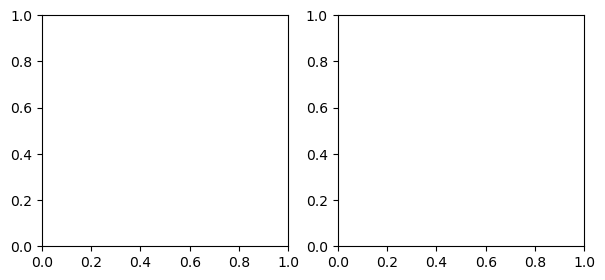

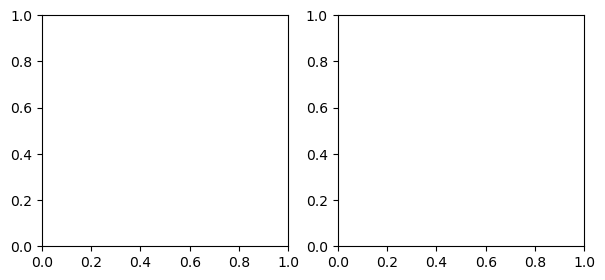

In [923]:
avg_loss = {'shared': [], 'separate': []}


for task_name in tasks:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        # ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [l[task_name] for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        avg_loss[exp_name].append(tl)
        
    


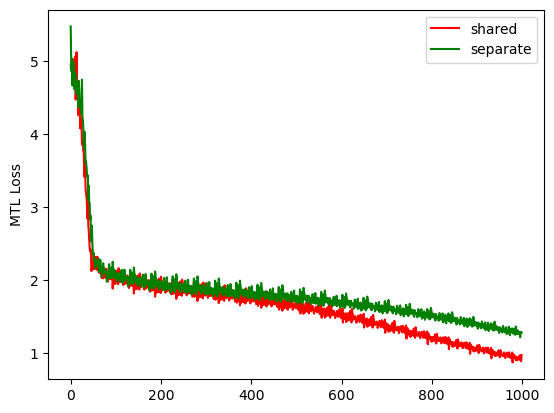

In [924]:
sh = np.array(avg_loss['shared']).mean(axis=0)
se = np.array(avg_loss['separate']).mean(axis=0)

# plot
ax = axes[0]
# tl_x, tl_y = zip(*tl)
plt.plot(range(len(sh)), sh, label=f'shared', color='red')#_{task_name}')
plt.plot(range(len(se)), se, label=f'separate', color='green')#_{task_name}')
plt.ylabel('MTL Loss')
# ax.set_yscale('log')
plt.legend()